In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split

import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn

import os
import pathlib

import snscrape.modules.twitter as sntwitter
import preprocessor as pp
import string
import datetime
import nltk
import re
import inspect

In [2]:
np.random.seed(0)
torch.random.manual_seed(0)
torch.cuda.manual_seed(0)

In [3]:
data_dir = '../data'
data_path = os.path.join(data_dir, 'TSLA.csv')
data_df = pd.read_csv(data_path)

In [ ]:
nltk.download('omw-1.4')
nltk.download('wordnet')

tokenizer = nltk.RegexpTokenizer(r"\w+")
lemmatizer = nltk.stem.WordNetLemmatizer()

Load GloVe embeddings in a dictionary

In [5]:
glove_dim = 100
token_to_vector = {}
with open(os.path.join(data_dir, f'./glove.6B/glove.6B.{glove_dim}d.txt'), encoding='utf-8') as f_glove:
    for line in f_glove:
        line = line.split()
        token_to_vector[line[0]] = [float(e) for e in line[1:]]

In [6]:
def tokenize_tweets(tweet):
    """
    Function to tokenize a tweet.
    """
    tokens = tokenizer.tokenize(tweet)
    tokens = [t.lower() for t in tokens]
    tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return tokens

In [7]:
tokenize_tweets('@user, @elonmusk; mothers feet and is at')

['user', 'elonmusk', 'mother', 'foot', 'and', 'is', 'at']

- Scrape, clean, and tokenize tweets. Query is formed with Twitter Advanced Search tool.

In [8]:
# data
tweets_clean = []
price_changes = []

min_faves = 500
query = f"tesla until:2022-12-31 since:2011-01-01 min_faves:{min_faves} lang:en -filter:links -filter:replies"

scraper = sntwitter.TwitterSearchScraper(query=query)
tweets = scraper.get_items()
cnt = 0
pp.set_options(pp.OPT.URL, pp.OPT.EMOJI)        # to clean-up URLs and emojis

for tweet in tweets:
    stock_data = data_df.loc[data_df['Date'] == str(tweet.date.date())]
    stock_data_prev = data_df.loc[data_df['Date'] == str((tweet.date - datetime.timedelta(days=1)).date())]
    if stock_data.shape[0]==0 or stock_data_prev.shape[0]==0:
        continue
    tweets_clean.append(tokenize_tweets(pp.clean(tweet.content)))
    price_changes.append(round(float(stock_data['Adj Close'].item()-stock_data_prev['Adj Close'].item()), 5))
    cnt += 1

print(cnt)

4102


- 01-01-2011 to 31-12-2022
    - min_faves:1000 - 1718
    - min_faves:500 - 4126
- 01-01-2022 to 31-12-2022
    - min_faves:500 - ~1600

In [9]:
data_dir = '../data/'
pathlib.Path(data_dir).mkdir(exist_ok=True, parents=True)
with open(os.path.join(data_dir, f'tweets_clean_2011-2022_min-faves{min_faves}.csv'), 'w') as f_csv:
    for i in range(len(tweets_clean)):
        f_csv.write(str(price_changes[i])+',')
        for token in tweets_clean[i]:
            f_csv.write(token+' ')
        f_csv.write('\n')

Padding
  - To make all tweets of same length; helpful in batching
  - Also allows `(hidden_dims*sequence_len) -> (output_dims)` FC layer after RNN. This is not used below, though

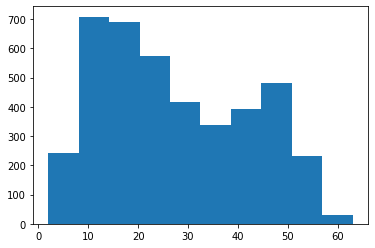

max_tweet_len: 63
Data shape: (4102, 63, 100) (4102, 1)


In [10]:
tweet_lens = []
for tweet in tweets_clean:
    tweet_lens.append(len(tweet))

plt.hist(tweet_lens)
plt.show()

max_tweet_len = max(tweet_lens)
print('max_tweet_len:', max_tweet_len)

X = np.zeros(shape=(len(tweets_clean), max_tweet_len, glove_dim), dtype=np.float64)       # default = padding = 0.
for i in range(len(tweets_clean)):
    X[i][:len(tweets_clean[i])] = np.array([token_to_vector[e] if e in token_to_vector else [0.0]*glove_dim for e in tweets_clean[i]])

Y = np.array(price_changes).reshape((len(price_changes),1))

print('Data shape:', X.shape, Y.shape)

In [13]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.1)                # test set
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.1)      # val set

print(X_train.shape, X_val.shape, X_test.shape, Y_train.shape, Y_val.shape, Y_test.shape)

def scale_data(X_train, Y_train, X_val, Y_val, X_test):
    X_scaler = MinMaxScaler()
    X_train_scaled = X_scaler.fit_transform(X_train)  # fit to training data (transform it as well)
    X_val_scaled = X_scaler.transform(X_val)
    X_test_scaled = X_scaler.transform(X_test)
    Y_scaler = MinMaxScaler()
    Y_train_scaled = Y_scaler.fit_transform(Y_train)
    Y_val_scaled = Y_scaler.transform(Y_val)
    return X_train_scaled, Y_train_scaled, X_val_scaled, Y_val_scaled, X_test_scaled, X_scaler, Y_scaler

shape_Xtrain = X_train.shape
X_train = X_train.reshape((shape_Xtrain[0], shape_Xtrain[1]*shape_Xtrain[2]))

shape_Xval = X_val.shape
X_val = X_val.reshape((shape_Xval[0], shape_Xval[1]*shape_Xval[2]))

shape_Xtest = X_test.shape
X_test = X_test.reshape((shape_Xtest[0], shape_Xtest[1]*shape_Xtest[2]))

X_train, Y_train, X_val, Y_val, X_test, X_scaler, Y_scaler = scale_data(X_train, Y_train, X_val, Y_val, X_test)

X_train = X_train.reshape((shape_Xtrain[0], shape_Xtrain[1], shape_Xtrain[2]))
X_val = X_val.reshape((shape_Xval[0], shape_Xval[1], shape_Xval[2]))
X_test = X_test.reshape((shape_Xtest[0], shape_Xtest[1], shape_Xtest[2]))

X_train = torch.from_numpy(X_train).float()
X_val = torch.from_numpy(X_val).float()
X_test = torch.from_numpy(X_test).float()
Y_train = torch.from_numpy(Y_train).float()
Y_test = torch.from_numpy(Y_test).float()
Y_val = torch.from_numpy(Y_val).float()

(3321, 63, 100) (370, 63, 100) (411, 63, 100) (3321, 1) (370, 1) (411, 1)


Check if data is balanced.

In [14]:
print("Total, Positive")
print(Y_train.shape[0], torch.sum(torch.from_numpy(Y_scaler.inverse_transform(Y_train))>0).item())
print(Y_val.shape[0], torch.sum(torch.from_numpy(Y_scaler.inverse_transform(Y_val))>0).item())
print(Y_test.shape[0], torch.sum(Y_test>0).item())

Total, Positive
3321 1611
370 188
411 189


Save data.

In [15]:
saved_data_name = f'2011-2022_min-faves{min_faves}.pt'
torch.save({
    'X_train': X_train,
    'X_test': X_test,
    'X_val': X_val,
    'Y_train': Y_train,
    'Y_test': Y_test,           # Y_test unscaled (coz it's not "available")
    'Y_val': Y_val,
    'X_scaler': X_scaler,
    'Y_scaler': Y_scaler,
}, os.path.join(data_dir,saved_data_name))

Optionally, (re-)load it.

In [45]:
dataset = torch.load(os.path.join(data_dir, saved_data_name))

X_train = dataset['X_train']
X_test = dataset['X_test']
X_val = dataset['X_val']
Y_train = dataset['Y_train']
Y_test = dataset['Y_test']
Y_val = dataset['Y_val']
X_scaler = dataset['X_scaler']
Y_scaler = dataset['Y_scaler']

glove_dim = X_train.shape[2]
max_tweet_len = X_train.shape[1]

In [16]:
batch_sz = 512

train_loader_kwargs = {
    'batch_size': batch_sz,
    'shuffle': True
}
train_loader = DataLoader(
    TensorDataset(X_train, Y_train), **train_loader_kwargs
)

test_loader_kwargs = {
    'batch_size': batch_sz,
    'shuffle': True
}
test_loader = DataLoader(
    TensorDataset(X_test, Y_test), **test_loader_kwargs
)

val_loader_kwargs = {
    'batch_size': batch_sz,
    'shuffle': True
}
val_loader = DataLoader(
    TensorDataset(X_val, Y_val), **val_loader_kwargs
)

`RNN_inbuilt` uses `torch.nn.RNN`.<br>
`RNN_scratch` doesn't.

In [17]:
class RNN_inbuilt(nn.Module):
    def __init__(self, input_size, output_size, hidden_size, num_layers, sequence_length):
        super().__init__()
        self.output_size = output_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size=input_size, hidden_size=hidden_size, num_layers=num_layers, batch_first=True)
                    # bias=True, nonlinearity='tanh'
        
        self.fc = nn.Linear(in_features=hidden_size*sequence_length, out_features=output_size)
        nn.init.xavier_uniform_(self.fc.weight)
        self.fc.bias.data.fill_(0.01)
    
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size)
        out, _ = self.rnn(x, h0)           # out: (batch size, sequence length, input dims)
        out = out.reshape(out.shape[0],-1)
        # out = out[:,-1,:]                         # doesn't work well!
        out = self.fc(out)
        return out


class RNN_scratch(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, sequence_length=None, use_all_timesteps=False):
        super().__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.sequence_length = sequence_length
        self.use_all_timesteps = use_all_timesteps

        if self.use_all_timesteps and (self.sequence_length is None):
            raise Exception(f"Error in {__class__.__name__}/{inspect.stack()[0][3]}: Cannot use entire sequence when sequence_length is None. Provide sequence_length as argument.")

        self.input2hidden = nn.Linear(input_size, hidden_size)
        self.hidden2hidden = nn.Linear(hidden_size, hidden_size)
        if self.use_all_timesteps:
            self.hidden2output = nn.Linear(hidden_size*sequence_length, output_size)
        else:
            self.hidden2output = nn.Linear(hidden_size, output_size)
        self.init_weights()           # doesn't affect performance here

    def forward_step(self, x, hidden_state):
        x = self.input2hidden(x)
        hidden_state = self.hidden2hidden(hidden_state)
        hidden_state = torch.tanh(x + hidden_state)
        return hidden_state

    def forward(self, inputs):
        curr_batch_size = inputs.shape[0]
        sequence_length = inputs.shape[1]
        hidden = self.init_hidden(curr_batch_size)
        hidden_concat = torch.empty(size=(curr_batch_size, sequence_length, self.hidden_size))
        for i in range(sequence_length):
            hidden = self.forward_step(inputs[:,i].reshape(curr_batch_size, self.input_size), hidden)
            hidden_concat[:,i,:] = hidden
        if self.use_all_timesteps:
            return self.hidden2output(hidden_concat.reshape(curr_batch_size,-1))
        else:
            return self.hidden2output(hidden_concat[:,-1,:])

    def init_weights(self):
        nn.init.xavier_uniform_(self.input2hidden.weight)
        nn.init.xavier_uniform_(self.hidden2hidden.weight)
        nn.init.xavier_uniform_(self.hidden2output.weight)
        self.input2hidden.bias.data.fill_(0.01)
        self.hidden2hidden.bias.data.fill_(0.01)
        self.hidden2output.bias.data.fill_(0.01)
    
    def init_hidden(self, batch_size):
        return torch.zeros(batch_size, self.hidden_size)

In [28]:
model_args = {
    'input_size': glove_dim,
    'output_size': 1,
    'hidden_size': 64,
    'num_layers': 1,
    'sequence_length': max_tweet_len,        # equals X_train.shape[1]
    # 'use_all_timesteps': True,
}
model = RNN_inbuilt(**model_args)
optim_args = {
    'lr': 1e-4
}
optimizer = torch.optim.Adam(model.parameters(), **optim_args)
loss_fn = nn.MSELoss()

In [29]:
def predict(model, loader):
    model.eval()
    preds = []
    with torch.no_grad():               # not training, so no need to calculate gradients
        for inputs, labels in loader:
            outputs = model(inputs)
            preds.append(outputs)
    preds = torch.cat(preds, axis=0)
    return preds

In [30]:
def train(num_epochs, print_width=None):
    dict_train_losses = {}
    dict_val_losses = {}
    print_width = max(1, num_epochs/10) if print_width is None else print_width

    for epoch in range(num_epochs):
        train_loss = 0
        cnt = 0

        model.train()
        
        for inputs, labels in train_loader:
            optimizer.zero_grad()
            
            outputs = model(inputs)

            # print(outputs.shape, labels.shape)
            assert outputs.shape==labels.shape                  # useful check

            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            
            train_loss += (loss.item()*inputs.shape[0])
            cnt += inputs.shape[0]

        train_loss /= cnt
        dict_train_losses[epoch] = train_loss
        with torch.no_grad():
            dict_val_losses[epoch] = loss_fn(predict(model,val_loader), Y_val)

        if epoch%print_width==0:
            print("Epoch:", epoch, "\tLoss:", train_loss)
        
    return dict_train_losses, dict_val_losses

In [31]:
dict_train_losses, dict_val_losses = train(200)

Epoch: 0 	Loss: 0.2608546005947265
Epoch: 20 	Loss: 0.022148559761178382
Epoch: 40 	Loss: 0.020424640608754586
Epoch: 60 	Loss: 0.01913345632224925
Epoch: 80 	Loss: 0.018164560000236335
Epoch: 100 	Loss: 0.017200067773959393
Epoch: 120 	Loss: 0.016407505010928566
Epoch: 140 	Loss: 0.015681655730887267
Epoch: 160 	Loss: 0.015106437063179472
Epoch: 180 	Loss: 0.014935262623509166


In [32]:
def plot_fn(x, y, fig=None, ax=None, figsize=(5,5), title='', xlabel='', ylabel='', xlims=None, ylims=None, dpi=None, marker=None):
    if fig is None or ax is None:
        fig, ax = plt.subplots(figsize=figsize)
    ax.plot(x, y, marker=marker, label=ylabel)
    if fig is None or ax is None:
        ax.set_xlabel(xlabel)
        ax.set_ylabel(ylabel)
        ax.set_title(title)
        if xlims is not None:
            ax.set_xlim(xlims)
        if ylims is not None:
            ax.set_ylim(ylims)
        if dpi is not None:
            fig.set_dpi(dpi)
    ax.legend()
    return fig, ax

def save_model(model, epochs, optimizer, path):
    torch.save({
        'epoch': epochs,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        }, path)

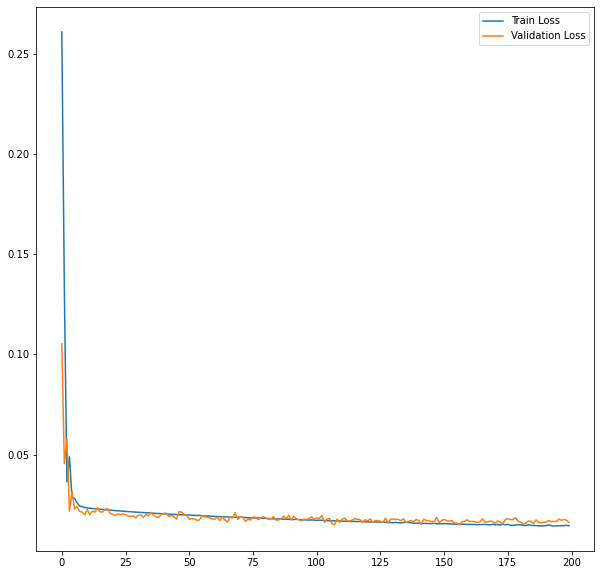

In [33]:
fig, ax = plot_fn(x=dict_train_losses.keys(), y=dict_train_losses.values(), figsize=(10,10), xlabel='Epoch', ylabel='Train Loss')
plot_fn(x=dict_val_losses.keys(), y=dict_val_losses.values(), fig=fig, ax=ax, figsize=(10,10), xlabel='Epoch', ylabel='Validation Loss')
fig.savefig('../results/sentiment/training_RNN_2011-2022_minfaves500_fin.png', bbox_inches='tight', facecolor='w')

In [34]:
preds = predict(model=model, loader=test_loader)
with torch.no_grad():
    # print(torch.nn.MSELoss()(torch.from_numpy(Y_scaler.inverse_transform(np.array(preds))), Y_test))
    print(torch.nn.MSELoss()(preds, torch.from_numpy(Y_scaler.transform(Y_test))))          # comparable to train, val loss
                                                                                            # as this is in transformed domain

tensor(0.0186, dtype=torch.float64)


In [39]:
def predict_tweets(tweets):
    """
    tweets      : List of tweets
    """
    pp.set_options(pp.OPT.URL, pp.OPT.EMOJI)        # to clean-up URLs and emojis

    tweets_clean_predict = []
    for tweet in tweets:
        tweet_clean = [token_to_vector[token] if token in token_to_vector else [0.0]*glove_dim for token in tokenize_tweets(pp.clean(tweet))]
        if len(tweet_clean)>max_tweet_len:
            tweet_clean = tweet_clean[:max_tweet_len]
        tweets_clean_predict.append(tweet_clean)

    X_predict = np.zeros(shape=(len(tweets_clean_predict), max_tweet_len, glove_dim), dtype=np.float64)
    for i in range(len(tweets_clean_predict)):
        X_predict[i][:len(tweets_clean_predict[i])] = np.array(tweets_clean_predict[i])
    
    shape_Xpredict = X_predict.shape
    X_predict = X_predict.reshape((shape_Xpredict[0], shape_Xpredict[1]*shape_Xpredict[2]))
    X_predict = torch.from_numpy(X_scaler.transform(X_predict)).float()
    X_predict = X_predict.reshape((shape_Xpredict[0], shape_Xpredict[1], shape_Xpredict[2]))

    Y_predict = torch.empty(size=(X_predict.shape[0], 1))       # just for the loader

    predict_loader = DataLoader(
        TensorDataset(X_predict, Y_predict), batch_size=X_predict.shape[0]
    )

    preds = predict(model, predict_loader)
    return preds

tweets = ['tesla stock is going to fall!', 'wow tesla stock is so much positive!']
print(Y_scaler.inverse_transform(predict_tweets(tweets)))

[[-0.95720973]
 [ 0.70595767]]


## Points

- Scaling is VERY important.
    - Saw this both in lagged-data prediction and sentiment analysis
- Loss increasing or fluctuating:
    - Try decreasing LR
- Plotting Validation Loss (along with Training Loss) helps know if there is over-fitting